<a href="https://colab.research.google.com/github/neSTORY/CartoonGAN_modified/blob/main/ReLu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Problem of Sigmoid

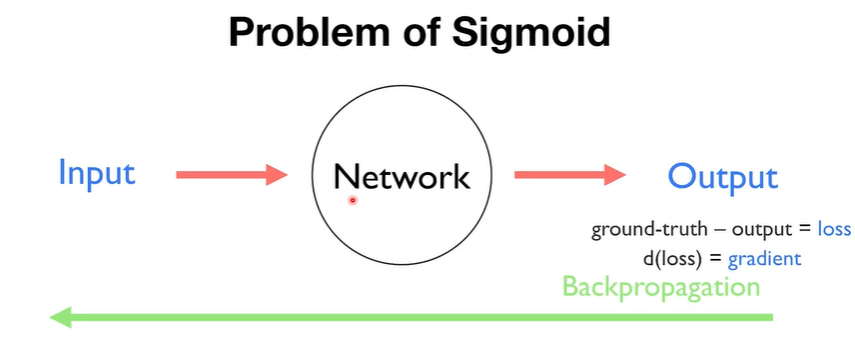

output으로 나온 값과 실제 값을 뺀 차이를 loss라고 하고 loss를 미분한 값을 기울기(gradient)라고 한다.

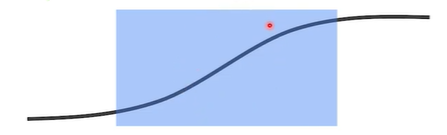

sigmoid의 중간 값의 기울기는 0보다 매우 큰 것을 볼 수 있다.

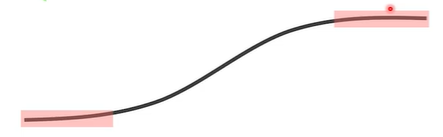

반면 양 끝단 값의 기울기는 0에 매우 가까운 것을 알 수 있다.

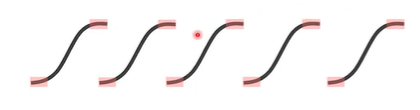

기울기 값이 0에 가까운 매우 작은 값이 한 두개면 상관이 없지만 layer층이 깊어지면 이러한 값들이 10개, 20개, 등 매우 많아지게 된다.

이렇게 되면 학습 시 네트워크가 전달 받는 기울기 값이 0에 가까운 값들을 받아 전달 받는 기울기 값이 없는 것과 마찬가지가 되게 된다. 이렇게 기울기 값이 소실되는 현상을 `Vanishing Gradient`라고 한다.

기울기 값이 소실되면서 학습이 잘 안 되는 점이 sigmoid의 문제점이라고 할 수 있다.

### ReLu

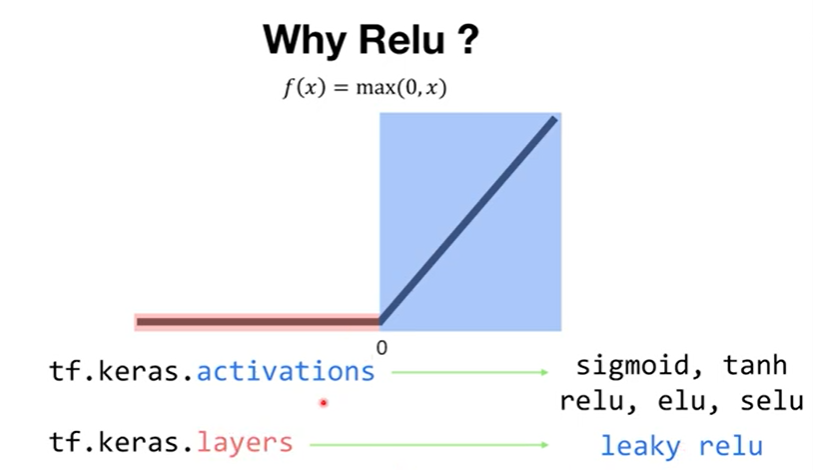

ReLu는 0보다 작은 값은 0으로 0보다 큰 값은 그대로 리턴해주는 함수이다.

미분을 하게 되면 0보다 작은 값은 기울기 값이 0, 0보다 큰 값은 기울기가 1로 나온다.

간단하지만 성능이 좋은 함수이다. 그렇지만 음수 값의 데이터들을 손실하게 되어서 이를 보완한 함수가 Leaky ReLu 함수이다.

## code

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from time import time
import os

In [ ]:
# tf.debugging.set_log_device_placement(True)

### Checkpoint function

In [ ]:
def load(model, checkpoint_dir):
  print(" [*] Reading checkpoints ... ")

  ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
  if ckpt:
    ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
    checkpoint = tf.train.Checkpoint(dnn=model)
    checkpoint.restore(save_path = os.path.join(checkpoint_dir, ckpt_name))
    counter = int(ckpt_name.split("-")[1])
    print(" [*] Succes to read {}".format(ckpt_name))

    return True, counter
  else:
    print(" [*] Failed to find a checkpoint")
    return False, 0

def check_folder(dir):
  os.makedirs(dir, exist_ok=True)
  return dir

### Data load & preprocessing function

In [ ]:
def load_mnist():
  (train_data, train_labels), (test_data, test_labels) = mnist.load_data()
  train_data = np.expand_dims(train_data, axis=-1) # [N, 28,28] -> [N, 28, 28, 1]
  test_data = np.expand_dims(test_data, axis=-1)

  train_data, test_data = normalize(train_data, test_data)

  train_labels = to_categorical(train_labels, 10)
  test_labels = to_categorical(test_labels, 10)

  return train_data, train_labels, test_data, test_labels

def normalize(train_data, test_data):
  train_data = train_data.astype(np.float32) / 255.0
  test_data = test_data.astype(np.float32) / 255.0

  return train_data, test_data

### Performance function

In [ ]:
def loss_fn(model, images, labels):
  logits = model(images, training=True)
  loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_pred=logits,
                                                                 y_true=labels,
                                                                 from_logits=True))
  return loss

def accuracy_fn(model, images, labels):
  logits = model(images, training=False)
  prediction = tf.equal(tf.argmax(logits,-1), tf.argmax(labels, -1)) # 제일 큰 수의 index 리턴
  accuracy = tf.reduce_mean(tf.cast(prediction, tf.float32))
  return accuracy

def grad(model, images, labels):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, images, labels)
    return tape.gradient(loss, model.variables)

### Model function

In [ ]:
def flatten():
  return tf.keras.layers.Flatten()

def dense(label_dim, weight_init):
  return tf.keras.layers.Dense(units=label_dim,
                               use_bias=True,
                               kernel_initializer=weight_init)

def sigmoid():
  return tf.keras.layers.Activation(tf.keras.activations.sigmoid)

### Create model(function version)

In [ ]:
def create_model(label_dim):
  weight_init = tf.keras.initializers.RandomNormal()

  model = tf.keras.Sequential()
  model.add(flatten()) 
  
  for i in range(2):
    model.add(dense(256, weight_init))
    model.add(sigmoid())

  model.add(dense(label_dim, weight_init))

  return model

### Define data & hyper-parameter

In [ ]:
# dataset
train_x, train_y, test_x, test_y = load_mnist()

# parameters
learning_rate = 0.001
batch_size = 128

training_epochs=1
training_iterations = len(train_x)//batch_size

label_dim = 10

train_flag = True

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
# Graph Input using dataset API
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y)).\
  shuffle(buffer_size=100000).\
  prefetch(buffer_size=batch_size).\
  batch(batch_size, drop_remainder=True)

test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y)).\
    shuffle(buffer_size=100000).\
    prefetch(buffer_size=len(test_x)).\
    batch(len(test_x))

### Define model & optimizer & writer

In [ ]:
# Model
network = create_model(label_dim)

# Training
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Writer
checkpoint_dir = "checkpoints"
logs_dir = "logs"

model_dir = "nn_softmax"

checkpoint_dir = os.path.join(checkpoint_dir, model_dir)
check_folder(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, model_dir)
logs_dir = os.path.join(logs_dir, model_dir)

### Restore checkpoint & start train or test phase

In [ ]:
if train_flag:
  checkpoint = tf.train.Checkpoint(dnn=network)

  # create writer for tensorboard
  summary_writer = tf.summary.create_file_writer(logdir=logs_dir)
  start_time = time()

  # restore check_point if it exits
  could_load, checkpoint_counter = load(network, checkpoint_dir)

  if could_load:
    start_epoch = (int)(checkpoint_counter / training_iterations)
    counter = checkpoint_counter
    print(" [*] Load SUCCESS !!")
  else:
    start_epoch = 0
    start_iteration = 0
    counter = 0
    print(" [!] Loard failed ... ")
  
  # train phase
  with summary_writer.as_default(): # for tensorboard
    for epoch in range(start_epoch, training_epochs):
      for idx, (train_input, train_label) in enumerate(train_dataset):
        grads = grad(network, train_input, train_label)
        optimizer.apply_gradients(grads_and_vars = zip(grads, network.variables))

        train_loss = loss_fn(network, train_input, train_label)
        train_accuracy = accuracy_fn(network, train_input, train_label)

        for test_input, test_label in test_dataset:
          test_accuracy = accuracy_fn(network, test_input, test_label)

        tf.summary.scalar(name="train_loss", data=train_loss, step=counter)
        tf.summary.scalar(name="train_accuracy", data=train_accuracy, step=counter)
        tf.summary.scalar(name="test_accuracy", data=test_accuracy, step=counter)
      
        print("Epoch : [{:3}] [{:5}/{:5}] time : {:4.4f}, train_loss : {:8.6f}, train_accuracy : {:8.4f}, test_accuracy : {:8.4f}".\
              format(epoch, idx, training_iterations, time()-start_time, train_loss, train_accuracy, test_accuracy))
        counter +=1
    checkpoint.save(file_prefix=checkpoint_prefix+"-{}".format(counter))

# test phase
else:
  _, _ = load(network, checkpoint_dir)
  for test_input, test_label in test_dataset:
    test_accuracy = accuracy_fn(network, test_input, test_label)

  print("test Accuracy : {:10.4f}".format(test_accuracy))

 [*] Reading checkpoints ... 
 [*] Failed to find a checkpoint
 [!] Loard failed ... 
Epoch : [  0] [    0/  468] time : 0.3447, train_loss : 0.361424, train_accuracy :   0.8984, test_accuracy :   0.9123
Epoch : [  0] [    1/  468] time : 0.4623, train_loss : 0.261011, train_accuracy :   0.9297, test_accuracy :   0.9124
Epoch : [  0] [    2/  468] time : 0.5921, train_loss : 0.305129, train_accuracy :   0.8984, test_accuracy :   0.9115
Epoch : [  0] [    3/  468] time : 0.7061, train_loss : 0.239477, train_accuracy :   0.9141, test_accuracy :   0.9110
Epoch : [  0] [    4/  468] time : 0.8578, train_loss : 0.242419, train_accuracy :   0.9375, test_accuracy :   0.9119
Epoch : [  0] [    5/  468] time : 0.9689, train_loss : 0.366843, train_accuracy :   0.8828, test_accuracy :   0.9123
Epoch : [  0] [    6/  468] time : 1.0942, train_loss : 0.377387, train_accuracy :   0.8906, test_accuracy :   0.9125
Epoch : [  0] [    7/  468] time : 1.2012, train_loss : 0.268945, train_accuracy :   0.9